In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os

def findFiles(path): return glob.glob(path)
print(findFiles('text_data/names/*.txt'))

['text_data/names/Czech.txt', 'text_data/names/German.txt', 'text_data/names/Arabic.txt', 'text_data/names/Japanese.txt', 'text_data/names/Chinese.txt', 'text_data/names/Vietnamese.txt', 'text_data/names/Russian.txt', 'text_data/names/French.txt', 'text_data/names/Irish.txt', 'text_data/names/English.txt', 'text_data/names/Spanish.txt', 'text_data/names/Greek.txt', 'text_data/names/Italian.txt', 'text_data/names/Portuguese.txt', 'text_data/names/Scottish.txt', 'text_data/names/Dutch.txt', 'text_data/names/Korean.txt', 'text_data/names/Polish.txt']


In [2]:
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )
#print(unicodeToAscii('Ślusàrski'))

category_lines = {}
all_categories = []

def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('text_data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

In [3]:
print(category_lines['Italian'][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


In [4]:
import torch

def letterToIndex(letter):
    return all_letters.find(letter)

def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))
print(lineToTensor('Jonesbaby').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([9, 1, 57])


In [5]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size+hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size+hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
    
    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden
    
    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [13]:
input = letterToTensor('A')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input, hidden)
print(output)

tensor([[-2.9061, -2.8327, -2.8387, -2.9332, -2.9917, -2.9069, -2.9178, -2.9388,
         -2.8357, -2.8629, -2.9232, -2.8838, -2.8626, -2.8298, -2.8271, -2.9418,
         -2.8769, -2.9368]], grad_fn=<LogSoftmaxBackward>)


In [14]:
input = lineToTensor('Kim')
hidden = torch.zeros(1, n_hidden)
output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-3.0262, -2.9519, -2.8622, -2.8519, -2.9731, -2.8126, -2.8522, -2.9470,
         -2.9840, -2.8272, -2.8698, -2.8428, -2.8620, -2.8400, -2.8245, -2.9296,
         -2.8385, -2.9685]], grad_fn=<LogSoftmaxBackward>)


In [15]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i
print(categoryFromOutput(output))

('Vietnamese', 5)


In [19]:
import random

def randomChoice(l):
    return l[random.randint(0,len(l)-1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)],dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category = ', category, '/ line = ', line)

category =  Arabic / line =  Tuma
category =  Portuguese / line =  Santana
category =  Italian / line =  Pesaresi
category =  Irish / line =  O'Hannigain
category =  French / line =  Duchamps
category =  Portuguese / line =  Melo
category =  Vietnamese / line =  Ngo
category =  Polish / line =  Adamczyk
category =  English / line =  Langley
category =  French / line =  David


In [20]:
criterion = nn.NLLLoss()
learning_rate = 0.005

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()
    rnn.zero_grad()
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
    
    loss = criterion(output, category_tensor)
    loss.backward()
    
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)
    
    return output, loss.item()

In [21]:
import time
import math
n_iters = 100000
print_every = 5000
plot_every = 1000

current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s/60)
    s -= m*60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss
    
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = 'O' if guess == category else 'X (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters*100, timeSince(start), loss, line, guess, correct))
        
        if iter % plot_every == 0:
            all_losses.append(current_loss / plot_every)
            current_loss = 0

5000 5% (0m 7s) 2.4725 Vandroogenbroeck / Greek X (Dutch)
10000 10% (0m 14s) 1.5854 Bobienski / Polish O
15000 15% (0m 21s) 2.7791 Rios / Greek X (Portuguese)
20000 20% (0m 28s) 1.6007 Beaulieu / French O
25000 25% (0m 36s) 3.4834 Crawford / French X (Scottish)
30000 30% (0m 43s) 1.4390 Ha / Vietnamese X (Korean)
35000 35% (0m 49s) 1.6756 Leverenz / Spanish X (German)
40000 40% (0m 57s) 1.0376 Zientek / Polish O
45000 45% (1m 4s) 0.6409 Jelohovtsev / Russian O
50000 50% (1m 11s) 0.6815 Shirasu / Japanese O
55000 55% (1m 19s) 0.3384 Tsumemasa / Japanese O
60000 60% (1m 26s) 0.7239 Yang / Chinese O
65000 65% (1m 33s) 1.5029 Romeijn / Irish X (Dutch)
70000 70% (1m 40s) 4.5454 Fergus / Portuguese X (Irish)
75000 75% (1m 46s) 0.9289 Di antonio / Italian O
80000 80% (1m 53s) 1.8796 Craig / Korean X (Scottish)
85000 85% (2m 0s) 2.1154 Rjavin / French X (Russian)
90000 90% (2m 7s) 2.7832 Kneib / Arabic X (German)
95000 95% (2m 14s) 1.9576 Maradona / Japanese X (Spanish)
100000 100% (2m 22s) 4.

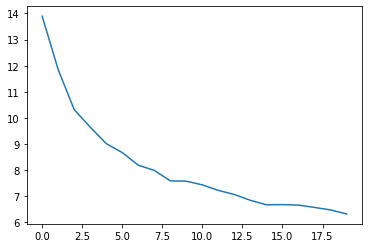

In [23]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

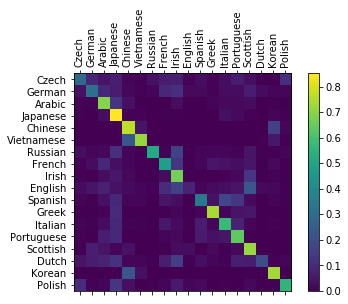

In [25]:
#confusion matrix 만들기

confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

def evaluate(line_tensor):
    hidden = rnn.initHidden()
    
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
        
    return output

for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1
    
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()
    
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

ax.set_xticklabels([''] + all_categories, rotation = 90)
ax.set_yticklabels([''] + all_categories)

ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()

In [26]:
def predict(input_line, n_predictions = 3):
    print('\n>%s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))
        
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []
        
        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' %(value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])
    
    
predict('Dovesky')
predict('Jackson')
predict('Satoshi')


>Dovesky
(-0.88) Czech
(-0.97) Russian
(-2.31) English

>Jackson
(-0.08) Scottish
(-3.28) English
(-4.13) Russian

>Satoshi
(-0.21) Japanese
(-2.45) Arabic
(-3.07) Italian


In [27]:
predict('Ngyen')


>Ngyen
(-0.65) Irish
(-1.92) English
(-1.97) Scottish


In [28]:
predict('Um')


>Um
(-0.97) Korean
(-1.62) Vietnamese
(-2.83) English


In [29]:
predict('Choi')


>Choi
(-0.37) Korean
(-1.66) Chinese
(-2.99) Arabic


In [30]:
predict('Kwak')


>Kwak
(-1.17) Korean
(-1.29) Polish
(-1.74) Chinese
